In [1]:
import numpy as np
import xarray as xr
#from dask.diagnostics import ProgressBar
from xgcm import Grid
from matplotlib import pyplot as plt
import dask
import dask.array as dsa
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [2]:
from dask.distributed import Client,LocalCluster
client = Client(scheduler_file='../scheduler.json')
print(client)

<Client: 'tcp://10.6.44.42:8752' processes=8 threads=8, memory=34.36 GB>


In [3]:
# uncomment to work with original dataset, otherwise use subsets below
# datapath = '/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/'
# diag_t = xr.open_mfdataset(datapath + 'outer_dia_*.nc', chunks={'ocean_time': 1}, combine='nested'
#                            ,concat_dim="ocean_time", data_vars='minimal', drop_variables = ['dstart', 'ntimes','nRST'])
# ts = xr.open_mfdataset(datapath + 'outer_avg_*.nc', chunks={'ocean_time': 1}, combine='nested'
#                            ,concat_dim="ocean_time", data_vars='minimal', drop_variables = ['dstart', 'ntimes','nRST'])

In [4]:
#print('Total Size: %6.2F GB' % (diag_t.nbytes / 1e9))

In [5]:
#print('Total Size: %6.2F GB' % (ts.nbytes / 1e9))

## Subset by time and space to make things a bit faster

In [6]:
# #BMP box
# # add 2 to every coord to account for angle of box isize=8 and jsize=10
# i = 65         # southward boundary
# ii = 73         # northward boundary
# j = 63         # westward boundary
# jj = 73         # eastward boundary
# ds = ts.isel(eta_psi=slice(i,ii-1), eta_rho=slice(i,ii), eta_u=slice(i,ii), eta_v=slice(i,ii-1),
#                xi_psi=slice(j,jj-1), xi_rho=slice(j,jj), xi_u=slice(j,jj-1), xi_v=slice(j,jj)).load()

# diag = diag_t.isel(eta_psi=slice(i,ii-1), eta_rho=slice(i,ii), eta_u=slice(i,ii), eta_v=slice(i,ii-1),
#                xi_psi=slice(j,jj-1), xi_rho=slice(j,jj), xi_u=slice(j,jj-1), xi_v=slice(j,jj)).load()

# print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))
# print('Total Size: %6.2F GB' % (diag.nbytes / 1e9))

In [7]:
# diag.to_netcdf('BMP_diag.nc')
# ds.to_netcdf('BMP_avg.nc')

In [9]:
diag = xr.open_mfdataset('BMP_diag.nc', chunks={'ocean_time': 1}, combine='nested'
                         ,concat_dim="ocean_time")
ds = xr.open_mfdataset('BMP_avg.nc', chunks={'ocean_time': 1}, combine='nested'
                            ,concat_dim="ocean_time")

# Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108

Here I also test to see if the new XGCM 'metrics' functionality works.

In [10]:
# Including metrics
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

/apps/pangeo/2020.05/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  app.launch_new_instance()
/apps/pangeo/2020.05/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.


In [11]:
#Set constants, and sanity check that xgcm is calculating areas and volumes right.
Cp = 4181.3
Rho_0 = 1025 
# Calculate volume the romstools way
Volume = ds.h/(ds.pm*ds.pn)        
V0 = Volume.sum(['eta_rho', 'xi_rho'])           
# Calculate volume the xgcm way
V_A = (ds.dA*ds.h).sum(['eta_rho', 'xi_rho'])
# Check that they match
print(V_A.values,V0.values)

[3.24524879e+11 3.24524879e+11 3.24524879e+11 ... 3.24524879e+11
 3.24524879e+11 3.24524879e+11] [3.24524879e+11 3.24524879e+11 3.24524879e+11 ... 3.24524879e+11
 3.24524879e+11 3.24524879e+11]


## Flux Divergence
First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be repeated for both tracers.

In [66]:
def tracer_flux_budget():
    """Calculate the convergence of fluxes of tracer. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -diag.temp_hadv.rename('conv_horiz_adv_flux_TH')
    conv_horiz_diff_flux = -diag.temp_hdiff.rename('conv_horiz_diff_flux_TH')
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = -diag['temp_vadv'].rename('conv_vert_adv_flux_TH')
    conv_vert_diff_flux = -diag['temp_vdiff'].rename('conv_vert_diff_flux_TH')

    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_TH')
    
    return xr.merge(all_fluxes + [conv_all_fluxes])

In [67]:
budget_th = tracer_flux_budget()

# Add it all up
The total tendency should be given by

In [68]:
budget_th['total_tendency_TH'] = (budget_th.conv_total_flux_TH) # + (budget_th.surface_flux_conv_TH.fillna(0.))
budget_th

<xarray.Dataset>
Dimensions:                  (eta_rho: 8, ocean_time: 8309, s_rho: 30, xi_rho: 10)
Coordinates:
    lat_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
    lon_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
  * s_rho                    (s_rho) float64 -0.9715 -0.9156 ... -0.004799
  * ocean_time               (ocean_time) datetime64[ns] 1994-01-01T12:00:00 ... 2016-09-30T12:00:00
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    conv_horiz_adv_flux_TH   (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 8, 10), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 8, 10), meta=np.ndarray>
    conv_vert_adv_flux_TH    (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 8, 10), meta=np.ndarray>
    conv_vert_diff_flux_TH   (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 8, 10), meta=np.ndarray>
    conv_total_flux_TH       (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 8, 10), meta=np.ndarray>
    total_tendency_TH        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 8, 10), meta=np.ndarray>

## Include the “truth”

In [69]:
budget_th['total_tendency_TH_truth'] = -diag.temp_rate 

In [70]:
# plt.figure(figsize=(12,6))
# (budget_th.total_tendency_TH.sum(dim=['s_rho', 'eta_rho', 'xi_rho'])).plot(linewidth=2, label = 'total 3D ADV and diff fluxes')
# (budget_th.total_tendency_TH_truth.sum(dim=['s_rho', 'eta_rho', 'xi_rho'])).plot(linestyle='--', linewidth=2, label='true temperature tendency')
# plt.legend()
# plt.ylabel('temperature rate of change [degC/day]')

In [71]:
# # Just the surface layer
# plt.figure(figsize=(12,6))
# (budget_th.total_tendency_TH[:,0,:,:].sum(dim=['eta_rho', 'xi_rho'])).plot(linewidth=2, label = 'total 3D ADV and diff fluxes')
# (budget_th.total_tendency_TH_truth[:,0,:,:].sum(dim=['eta_rho', 'xi_rho'])).plot(linestyle='--', linewidth=2, label='true temperature tendency')
# plt.legend()
# plt.ylabel('temperature rate of change [degC/day]')

# Validate Budget¶
Now we do some checks to verify that the budget adds up.

## Vertical and Horizontal Integrals of Budget
We will take an average over the first 10 timesteps

In [72]:
time_slice = dict(ocean_time=slice(0, 10))

In [73]:
def check_horizontal(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .sum(dim=['s_rho', 'xi_rho']).mean(dim='ocean_time'))
    return ds_chk

def check_vertical(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .sum(dim=['eta_rho', 'xi_rho']).mean(dim='ocean_time'))
    return ds_chk

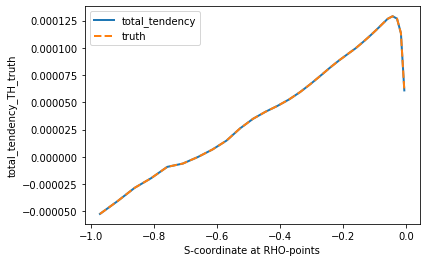

In [74]:
th_vert = check_vertical(budget_th.isel(**time_slice), 'TH').load()
th_vert.total_tendency_TH.plot(linewidth=2, label = 'total_tendency')
th_vert.total_tendency_TH_truth.plot(linestyle='--', linewidth=2, label='truth')
plt.legend()


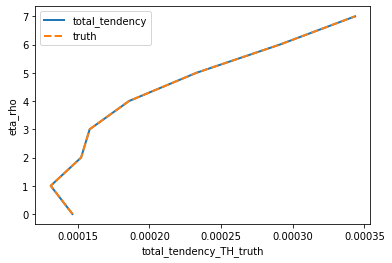

In [75]:
th_horiz = check_horizontal(budget_th.isel(**time_slice), 'TH').load()
th_horiz.total_tendency_TH.plot(linewidth=2, y='eta_rho',label='total_tendency')
th_horiz.total_tendency_TH_truth.plot(linestyle='--', linewidth=2, y='eta_rho',label='truth')
plt.legend()

## Sum up terms in surface layer over length of the timeseries and plot as bar chart

In [76]:
budget_th_tot = (budget_th.isel(s_rho=0).sum(dim=['eta_rho','xi_rho','ocean_time'])).load()

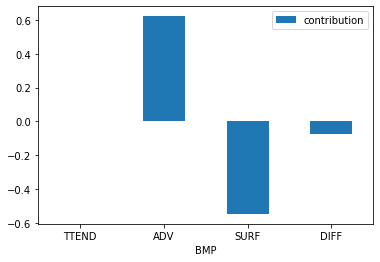

In [77]:
ADV = budget_th_tot.conv_horiz_adv_flux_TH + budget_th_tot.conv_vert_adv_flux_TH
import pandas as pd
df = pd.DataFrame({'BMP':['TTEND', 'ADV', 'SURF', 'DIFF'], 'contribution':[budget_th_tot.total_tendency_TH_truth.values
                                                             ,ADV.values
                                                             ,budget_th_tot.conv_vert_diff_flux_TH.values
                                                             ,budget_th_tot.conv_horiz_diff_flux_TH.values]})
df.contribution=df.contribution.astype(float)
ax = df.plot.bar(x='BMP', y='contribution', rot=0)
plt.savefig('BMP_heat_terms_bar_plot.png', dpi=300,bbox_inches='tight')

In [78]:
budget_th_box = (budget_th.isel(s_rho=0).sum(dim=['eta_rho','xi_rho'])).load()

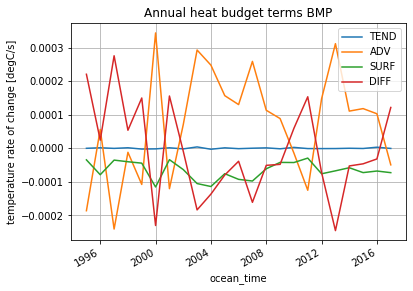

In [79]:
# Plot temperature tendency
budget_th_box.total_tendency_TH_truth.resample(ocean_time='1Y').mean().plot(label='TEND')
(budget_th_box.conv_horiz_adv_flux_TH + budget_th_box.conv_vert_adv_flux_TH).resample(ocean_time='1Y').mean().plot(label='ADV')
budget_th_box.conv_vert_diff_flux_TH.resample(ocean_time='1Y').mean().plot(label='SURF')
budget_th_box.conv_horiz_diff_flux_TH.resample(ocean_time='1Y').mean().plot(label='DIFF')
plt.legend()
plt.grid()
plt.title('Annual heat budget terms BMP')
plt.ylabel('temperature rate of change [degC/s]')
plt.savefig('BMP_heat_terms_annual_mean.png', dpi=300,bbox_inches='tight')

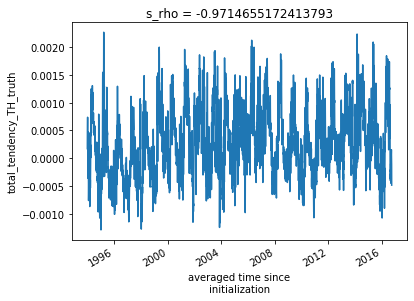

In [65]:
budget_th_box.total_tendency_TH_truth.cumsum().plot(label='TEND')